In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

from utils import *
from methods import *
from models import *
from plotting_functions import *

In [ ]:
# load trained model
model = torch.load('./optimal-models/JV7')
phases = model.phases.clone().detach().numpy()
print(phases)
wrapped_phases = model.unit_cell.wrap(phases)
print(wrapped_phases)
print(phases - wrapped_phases)

[[-0.13768111 -0.17997013]
 [-0.28053814 -0.5923632 ]
 [ 0.2908902  -0.09749148]
 [ 0.4337475   0.3149015 ]
 [-0.42339548  0.1499443 ]
 [ 0.14803317  0.6448163 ]
 [ 0.00517602  0.2324229 ]]
[[-0.13768111 -0.17997013]
 [-0.28053814  0.56233736]
 [ 0.29089019 -0.09749148]
 [ 0.4337475   0.3149015 ]
 [-0.42339548  0.14994431]
 [ 0.14803317 -0.50988426]
 [ 0.00517602  0.2324229 ]]
[[ 0.00000000e+00  0.00000000e+00]
 [-6.10622664e-16 -1.15470054e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 1.66533454e-16  1.15470054e+00]
 [ 0.00000000e+00  0.00000000e+00]]


[(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>),
 (<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)]

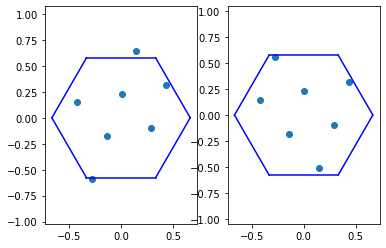

In [ ]:
fig, axs = plt.subplots(ncols=2)
axs[0].scatter(*phases.T)
axs[1].scatter(*wrapped_phases.T)
[axs[i].axis('equal') for i in range(len(axs))]
[model.unit_cell.plot(fig,axs[i]) for i in range(len(axs))]

In [ ]:
np.linalg.norm(model.unit_cell.basis[0])

0.5773502691896257

In [ ]:
model.unit_cell.basis @ np.array([0.14803317, 0.6448163])

array([ 0.26015902,  0.37228486,  0.11212585, -0.26015902, -0.37228486,
       -0.11212585])

In [ ]:
model.unit_cell.is_in_hexagon(np.array([[0.14803317, 0.6448163]]))

array([False])

In [ ]:
model.unit_cell.wrap(np.array([[0.14803317, 0.6448163]]))

array([[ 0.14803317, -0.50988424]])

In [ ]:
phases[1:2]

array([[-0.28053814, -0.5923632 ]], dtype=float32)

In [ ]:
model.unit_cell.wrap(phases[1:2])

array([[-0.28053814,  0.56233736]])

In [ ]:
model.unit_cell.basis[1]

array([8.32667268e-17, 5.77350269e-01])

In [ ]:
np.array([0.14803317, 0.6448163]) @ model.unit_cell.basis[1], np.linalg.norm(model.unit_cell.basis[1])

(0.37228486438285846, 0.5773502691896257)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

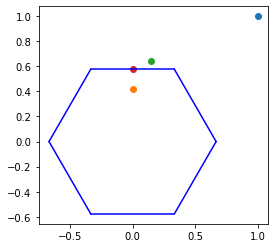

In [ ]:
fig, ax = plt.subplots()
ax.scatter(1,1)
ax.scatter(*model.unit_cell._wrap(np.ones(2)))
ax.scatter(*np.array([0.14803317, 0.6448163]))
ax.scatter(*model.unit_cell.basis[1])
model.unit_cell.plot(fig,ax)

### Test (Linear) decoding performance

In [ ]:
def test_decoding(model,nsamples_space=1000):
    r = model.unit_cell.sample(nsamples_space)
    activity = model.forward(torch.tensor(r,dtype=torch.float32))
    r_pred = model.decode(activity)
    r_pred = r_pred.detach().numpy()
    #r_wrapped = model.unit_cell.wrap(r_pred)
    return r, model.unit_cell.geodesic(r,r_pred)#np.sum((r-r_wrapped)**2,axis=-1)

In [ ]:
r = model.unit_cell.sample(1000)
r = torch.tensor(r,dtype=torch.float32)
model.train_decoder(r)

tensor([[-0.3137, -0.4588],
        [-0.1164,  0.0102],
        [ 0.5299, -0.1795],
        [ 0.1117,  0.1149],
        [-0.3861,  0.1311],
        [ 0.1417, -0.1522],
        [ 0.0217,  0.5495]], grad_fn=<MmBackward0>)

0.2370401219709936


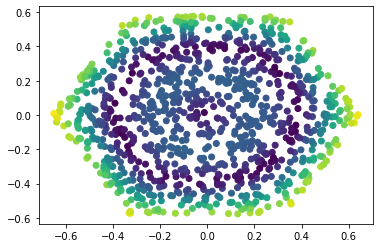

In [ ]:
r, decoding_error = test_decoding(model)
print(np.mean(decoding_error))
plt.scatter(*r.T,c=decoding_error)

### Show The Jacobian

In [ ]:
def test_detJ(model,nsamples_space=1000):
    r = model.unit_cell.sample(nsamples_space)
    J = model.jacobian(torch.tensor(r,dtype=torch.float32))
    det_J = model.the_jacobian(J)
    return r,det_J.detach().numpy()

In [ ]:
r,detJ = test_detJ(model)

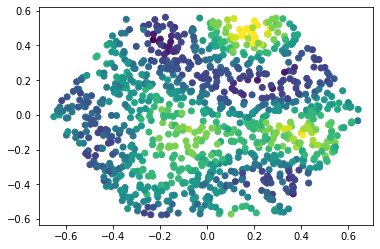

In [ ]:
plt.scatter(*r.T,c=detJ)

### Show (low-dimensional projection) manifold

In [ ]:
def show_manifold(model,nsamples_space=10000):
    import umap
    r = model.unit_cell.sample(nsamples_space)
    #r = create_board(1).reshape(-1,2)
    activity = model.forward(torch.tensor(r,dtype=torch.float32)).detach().numpy()
    projection = umap.UMAP(n_components=3)
    return projection.fit_transform(activity), projection, activity

In [ ]:
manifold, projection, activity = show_manifold(model)

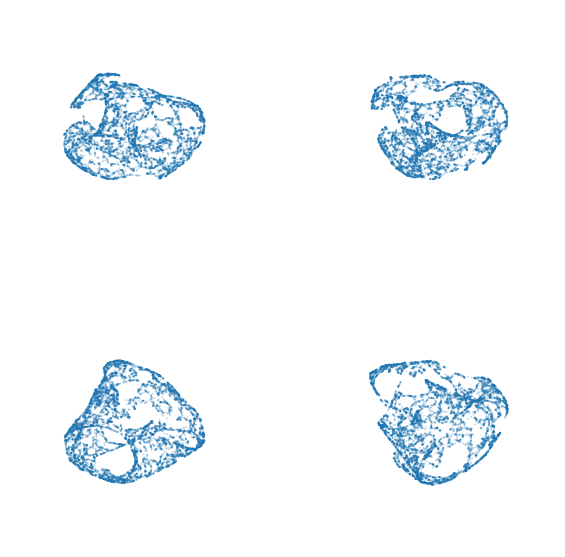

In [ ]:
scatter3d(manifold,ncols=2,nrows=2,azim_elev_title=False,figsize=(10,10),alpha=0.2);

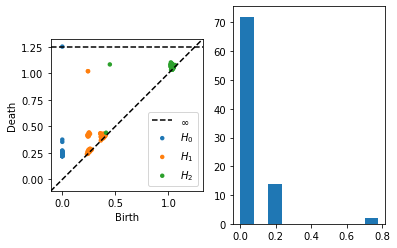

In [ ]:
from ripser import ripser
from persim import plot_diagrams
fig,axs = plt.subplots(ncols=2)
#dgms = ripser(g,maxdim=2,n_perm=150)['dgms']
dgms = ripser(activity,maxdim=2,n_perm=150)['dgms']
plot_diagrams(dgms, show=False, ax=axs[0])
axs[1].hist(dgms[1][:,1] - dgms[1][:,0]);